In [ ]:
from src.v4.torchdata import load_vals, print_formatted_table
from src.v5.problem import symbolic, FunctionSympy
from src.v6.problem import MFunctionalSet, MFunctionalSetLeaf, build_leafs
from graph.matrixview import render_incidence
from graph.graphutils import default_tree, flat_graph_formulation
from graph.operators import sort_scc
from scipy import optimize
import numpy as np

In [2]:
x, m1, m2, mt = symbolic("x", "m1", "m2", "mt")
D1 = MFunctionalSetLeaf(m1 == x**2-2*x+3)
D2 = MFunctionalSetLeaf(m2 == 0.5*mt) 
D3 = MFunctionalSetLeaf(mt == m1+m2)
C = MFunctionalSet().functionalsubsetof(D1, D2, D3).subsetof(
    0 <= x, x <= 10,
).minimize(mt)
# T = optimal_configuration_tree(C)
# P = C.config_with_tree(T) # automatic
D23 = MFunctionalSet().functionalsubsetof(D2, D3) 
P = C.config(elim=[D1, D23.config(residuals=[D2, D3])])

In [3]:
sets, _,_,_, indices = C.gather_sets()

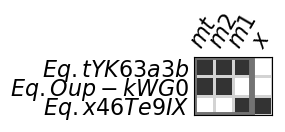

In [4]:
idxrev = {var.item():key for key,var in indices.items()}
in_outs = {eqid: D.analysis.structure for eqid, D in sets.items()}
Ein = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[0]) for eqid, item in in_outs.items()}
Eout = {eqid: tuple(str(idxrev[idx.item()]) for idx in item[1]) for eqid, item in in_outs.items()}
edges = Ein, Eout, {}
tree = default_tree(Ein.keys())
render_incidence(edges, tree, rawvarname=True, dispendcomp=False, hideticks=True, patchwidth=4, figsize=((1,1)),diagonalgray=False);

In [5]:
G = flat_graph_formulation(Ein, Eout)
order_id = sort_scc(G)

In [ ]:
# We build just the skeleton of the configuration
sets_processed = []
for elt in order_id:
    supersets = [MFunctionalSetLeaf((elt_id.name, None), autoid=False) for elt_id in elt]
    if len(supersets) == 1:
        sets_processed.append(supersets[0])
    else:
        sets_processed.append(MFunctionalSet(*supersets).config(residuals=supersets))
MDA_SCC = MFunctionalSet(*sets_processed).config(elim=sets_processed)

In [8]:
f = MDA_SCC.build(sets=sets, indices=indices)

In [9]:
x0 = {"x": 0, "m1": 0, "m2": 0, "mt": 0}
xidxed = load_vals(x0, indices, isdict=True)

In [11]:
f.analysis(xidxed)

tensor([3., 0., 3., 6.], dtype=torch.float64)

In [4]:
obj_function, dobj, xguess, constraints = P.build_opt(x0=xidxed)

In [5]:
xsol = optimize.minimize(obj_function, xguess, jac=dobj, constraints=constraints, method="SLSQP", options={"disp": True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.0
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2


In [16]:
f = P.build()

In [17]:
idxrev = {var.item():key for key,var in indices.items()}
xsolidxrev = {var.item():key for key,var in indices.items()}
print_formatted_table([f.analysis(xidxed)], indices, idxrev)

m2 mt x m1
2  4  1 2 


In [6]:
f = P.build()

In [9]:
idxrev = {var.item():key for key,var in indices.items()}
print_formatted_table([f.analysis(xidxed)], indices, idxrev)

x      mt m1 m2
0.00e0 6  3  3 


In [18]:
x0 = {"x": 0.5, "m1": 0.5, "m2": 1.5, "mt": 2}
_, indices = P.gather_sets()
xidxed = load_vals(x0, indices, isdict=True)
f1.analysis(xidxed)
#f1.analysis.structure

tensor([2.2500, 1.0000, 0.5000, 3.2500], dtype=torch.float64)

In [ ]:
P.solve(x0 = {"x": 1, "m1": 1, "m2": 1, "mt": 1})

In [2]:
n = 5
A = np.random.rand(n, n)
# Ensure the matrix is invertible (has a unique solution)
while np.linalg.det(A) == 0:
    A = np.random.rand(n, n)
xval = np.random.rand(n)
b = np.dot(A, xval)

In [3]:
x1,x2,x3,x4,x5 = symbolic("x1", "x2", "x3", "x4", "x5")
vars = np.array([x1,x2,x3,x4,x5])
sets = []
for i in range(n):
    rhs = ((np.hstack((A[i, :i], A[i, (i+1):],  [b[i]]))) / A[i, i])@np.hstack((-vars[:i], -vars[(i+1):], [1]))
    print(rhs)
    lhs = vars[i]
    sets.append(MFunctionalSetLeaf(lhs == rhs))
C = MFunctionalSet().functionalsubsetof(*sets)
set_info = C.gather_sets()
sets, indices = set_info
D1, D2, D3, D4, D5 = C.supersets

-0.081045735310219*x2 - 0.935997496081404*x3 - 0.609905921352857*x4 - 0.58282534888973*x5 + 1.91444008000305
-0.69843893517421*x1 - 1.14646784858583*x3 - 0.675464702408195*x4 - 1.44304260660306*x5 + 3.05349412927818
-24.8692581114842*x1 - 2.16027798559865*x2 - 5.88099058398598*x4 - 13.8119347370602*x5 + 19.1963845585831
-0.136176567340161*x1 - 0.26098762893159*x2 - 0.382661612683617*x3 - 0.904031506155156*x5 + 1.95851036688496
-1.56838516799004*x1 - 1.26705846322546*x2 - 3.02901878589248*x3 - 1.24176493735535*x4 + 5.18142193175845


In [ ]:
r1 = C.config(elim=[D1,D2], parallel=[D3,D4,D5]).build(*set_info, return_residual=True)

In [7]:
xguess = np.random.rand(n)
x0 = {'x1': xguess[0], 'x2': xguess[1], 'x3': xguess[2], 'x4': xguess[3], 'x5': xguess[4]}
xidxed = load_vals(x0, indices, isdict=True)
# xsol = r1(xidxed)
# idxrev = {var.item():key for key,var in indices.items()}
# print_formatted_table([xsol], indices, idxrev, subset=None)
r1(xidxed)

tensor([-4.9629,  0.3645, -0.4044], dtype=torch.float64)

In [8]:
xval

array([0.97677073, 0.62873461, 0.82866185, 0.02100109, 0.05768584])

In [8]:
idxrev = {var.item():key for key,var in indices.items()}
in_outs = [D.analysis.structure for D in sets.values()]
Ein = {i: tuple(str(idxrev[idx.item()]) for idx in item[0]) for i, item in enumerate(in_outs)}
Eout = {i: tuple(str(idxrev[idx.item()]) for idx in item[1]) for i, item in enumerate(in_outs)}
edges = Ein, Eout, {}
tree = default_tree(Ein.keys())

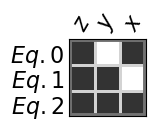

In [10]:
render_incidence(edges, tree, rawvarname=True, dispendcomp=False, hideticks=True, patchwidth=4, figsize=((1,1)),diagonalgray=False);

In [29]:
f1 = C.config(elim=[D2, D3], parallel=[D1]).build(*set_info, 
                                                  return_residual=False) 
r1 = C.config(residuals=[D1, D2, D3]).build(*set_info, 
                                            return_residual=True) 

In [30]:
x0 = {'x': 1, 'y': 2.8, 'z': 3}
xval = load_vals(x0, indices, isdict=True)

In [31]:
xsol = f1(xval)
r1(xsol)

tensor([0.0000e+00, 2.2204e-16, 0.0000e+00], dtype=torch.float64)

In [32]:
xval

tensor([2.8000, 1.0000, 3.0000], dtype=torch.float64)

In [7]:
x, y1, y2, z1, z2 = symbolic("x", "y1", "y2", "z1", "z2")
D1 = MFunctionalSet(y1 == z1**2+z2+x-0.2*y2)
D2 = MFunctionalSet(y2 == y1**0.5+z1+z2)
C = MFunctionalSet().functionalsubsetof(D1, D2)
set_info = C.gather_sets()
sets, indices = set_info

In [5]:
f1 = C.config(elim=[D1], residuals=[D2]).build(*set_info, return_residual=True) #residual
f2 = C.config(elim=[D1, D2]).build(*set_info) # analysis, but invalid
#f2 = C.config(parallel=[D1, D2]).build(*set_info) # analysis, but valid

In [6]:
x0 = {'z1': 1, 'z2': 2, 'x': 3}
xval = load_vals(x0, indices, isdict=True)

In [ ]:
x, m1, m2, mt = symbolic("x", "m1", "m2", "mt")
D1 = MFunctionalSetLeaf(m1 == x**2-2*x+10)
# Alternative 1
D21 = MFunctionalSetLeaf(m2 == 0.1*mt) 
D22 = MFunctionalSetLeaf(mt == m1+m2)
D2 = MFunctionalSet().functionalsubsetof(D21, D22)
# Alternative 2
D2 = MFunctionalSet(
    m2 == 0.1*mt, 
    mt == m1+m2
)
[D21, D22] = D2.supersets
C = MFunctionalSet().functionalsubsetof([D1, D2]).subsetof(
    0 <= x <= 10,
).minimize(mt)

P = C.config(elim=[D1, D2.config(parallel=[D21, D22])]) # requires alternative 1
P.solve(x0 = {"x": 1, "m1": 1, "m2": 1, "mt": 1})

In [ ]:
x, y1, y2, z1, z2 = symbolic("x", "y1", "y2", "z1", "z2")
D1 = MFunctionalSetLeaf(y1 == z1**2+z2+x-0.2*y2)
D2 = MFunctionalSetLeaf(y2 == y1**0.5+z1+z2)
C = MFunctionalSet().functionalsubsetof(D1, D2).subsetof(
    3.16 <= y1,
    y2 >= 24.0,
    0 <= x <= 10,
    0 <= z1 <= 10,
    0 <= z2 <= 10
).minimize(x**2+z2+y1+sp.exp(-y2))

P = C.config(elim=[D1], parallel=[D2]) 
P.solve(x0 = {"x": 1, "z1": 2, "z2": 3})

In [ ]:
x, m1, m2, mt = symbolic("x", "m1", "m2", "mt")
D1 = MFunctionalSetLeaf(m1 == x**2-2*x+3)
D2 = MFunctionalSetLeaf(m2 == 0.5*mt) 
D3 = MFunctionalSetLeaf(mt == m1+m2)
C = MFunctionalSet().functionalsubsetof(D1, D2, D3).subsetof(
    0 <= x <= 10,
).minimize(mt)
# T = optimal_configuration_tree(C)
# P = C.config_with_tree(T) # automatic
D23 = MFunctionalSet().functionalsubsetof([D2,D3]); 
P = C.config(elim=[D1, D23.config(parallel=[D2, D3])]) # manual
P.solve(x0 = {"x": 1, "m1": 1, "m2": 1, "mt": 1})

# Aero Example

In [ ]:
A,V,S,W,Ww,CL,Re,Cf,CD,D = symbolic('A','V','S','W','Ww','C_L','Re','C_f','C_D','D')
rho,mu,k,t,e,CDA,SwetS,W0,pi = 1.23, 1.78e-5, 1.2, 0.12, 0.96, 0.0306, 2.05, 4940, 3.14

Aero = MFunctionalSet(
    CL == 2*W/(rho*V**2*S),
    Re == rho*V/mu*(S/A)**(1/2),
    Cf == 0.074/Re**0.2,
    CD == CDA/S+k*Cf*SwetS+CL**2/(3.14*A*e),
    D == 0.5*rho*V**2*CD*S
)
Struct1 = MFunctionalSet(
    Ww == 45.42*S+8.71e-5*2.5/t*A**(3/2)*S**(1/2)*(W0*W)**(1/2),
)
Struct2 = MFunctionalSet(
    W == W0+Ww
)

Struct = MFunctionalSet().functionalsubsetof(Struct1, Struct2)
AeroStruct = MFunctionalSet().functionalsubsetof(Aero, Struct)
#AeroStruct = MFunctionalSet().functionalsubsetof(Aero, Struct1, Struct2) # also valid
set_info = AeroStruct.gather_sets()
sets, indices = set_info

In [ ]:
AeroStruct.residuals(elim=[Aero.analysis()], Struct.residuals())

## MDA 1

In [ ]:
# Config 1
C1 = AeroStruct.config(elim=[Struct.config(parallel=[Struct1, Struct2]), Aero]).build(*set_info)

## MDA 2

In [ ]:
# Config 2
StructSolver = Struct.config(elim=[Struct1])
C1 = AeroStruct.config(parallel=[StructSolver, Aero]).build(*set_info)

## IDF

In [ ]:
IDF = AeroStruct.config(constraints=Aero.constraints+Struct.constraints)

## AAO

In [ ]:
AAO = AeroStruct.config(constraints=Aero.constraints+Struct.constraints).residuals()